In [1]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

# Read scenario data

Refer to **read_data.ipynb** for insight regarding how the data is generated and structured.

In [2]:
with open('Data/250_scenarios.json') as f:
    scenarios = json.load(f)

scenarios.keys()

dict_keys(['Sample Scenarios', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '

# One-price Scheme (RESULTS NEED VALIDATION as they are a bit strange)

*(Task 1.a)*

## Run model

In [85]:
OMEGA = len(scenarios.keys()) - 1 # number of scenarios
T = 24 # number of hours
PI = 1 / OMEGA # probability of each scenario - assumed to be equal
WIND_CAPACITY = 200 #MWh

direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

#============= Variables =============
p_DA = m.addVars(T, lb=0, ub=gb.GRB.INFINITY, name="p_DA") # day-ahead power bid
delta = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="delta") # decision variable for the power imbalance - can be negative
price_coeff = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="K") # price coefficient for the imbalance price wrt. the day-ahead price

#============= Objective function =============
# Set objective function - note that the day-ahead price is factored out of the sum
obj = gb.quicksum(PI * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * (p_DA[t] + price_coeff[t,w] * delta[t,w]) for t in range(T) for w in range(OMEGA))
m.setObjective(obj, direction)

#============= Day-ahead power bid limits ============

#Upper limit is the nominal wind power
m.addConstrs(p_DA[t] <= WIND_CAPACITY for t in range(T))

#============= Power imbalance definition (realized - bid) ===============
m.addConstrs(delta[t,w] == scenarios[str(w)]['Wind Power [MW]'][t] - p_DA[t] for t in range(T) for w in range(OMEGA))

#============= Price coefficient definition ===============
# the system balance parameter is 0 if the system has a surplus and 1 if it has a deficit
m.addConstrs(price_coeff[t,w] == 1.2 * scenarios[str(w)]['System Balance State'][t] + 0.9 * (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))

#============= Display and run model =============
m.update()
#m.display()
m.optimize()

#============= Results =============
if m.status == gb.GRB.OPTIMAL:
    #initialization
    results = {}
    for scenario in range(OMEGA):
        df = pd.DataFrame(columns=['Hour', 'DA Price [EUR/MWh]', 'Wind Power [MW]', 'DA Bid [MW]', 'Imbalance [MW]', 'DA Profit [EUR]', 'Balancing Profit [EUR]', 'System State', 'Balancing Price Coefficient'])
        
        for t in range(T):
            df.loc[t] = [t, 
                         scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t], 
                         scenarios[str(scenario)]['Wind Power [MW]'][t], p_DA[t].x, 
                         delta[t,scenario].x, scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * p_DA[t].x, 
                         price_coeff[t,scenario].x * scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * delta[t,scenario].x, 
                         scenarios[str(scenario)]['System Balance State'][t], price_coeff[t,scenario].x]
        df['Total Profit [EUR]'] = df['DA Profit [EUR]'] + df['Balancing Profit [EUR]']

        df['Hour'] = df['Hour'].astype(int)
        df['System State'] = df['System State'].astype(int)
        df['System State'] = df['System State'].apply(lambda x: 'Deficit' if x == 1 else 'Surplus')
        df.set_index('Hour', inplace=True)
        results[scenario] = df.copy(deep=True)

    print('-----------------------------------------------')
    print('Objective value (expected profit): %.2f EUR' % m.objVal)
    print('-----------------------------------------------')
    print('Day-ahead bids:')
    average_hourly_profit = np.mean([results[w]['Total Profit [EUR]'] for w in range(OMEGA)], axis=0)

    summary = pd.DataFrame(columns=['Hour', 'DA Bid [MW]', 'Average Profit [EUR]'])
    for t in range(T):
        summary.loc[t] = [t, p_DA[t].x, average_hourly_profit[t]]
    summary['Hour'] = summary['Hour'].astype(int)
    summary.set_index('Hour', inplace=True)

    results['Summary'] = summary.copy(deep=True)

    for t in range(T):
        print('Hour %d | Bid: %.2f MW | Average Profit: %.2f EUR' % (t, p_DA[t].x, average_hourly_profit[t]))

    print('Sum of average profits: %.2f EUR' % np.sum(average_hourly_profit))
    print('-----------------------------------------------')
    print('Runtime: %f ms' % (m.Runtime * 1e3))
else:
    print("Optimization was not successful.")     

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 12024 rows, 12024 columns and 18024 nonzeros
Model fingerprint: 0xd9861b39
Model has 6000 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+01, 1e+02]
  QObjective range [5e-02, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 2e+02]
Presolve removed 12024 rows and 12024 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.01 seconds (0.01 work units)
Optimal objective 1.88326447e+05
-----------------------------------------------
Objective value (expected profit): 188326.45 EUR
-----------------------------------------------
Day-ahead bids:
Hour 0 | Bid: 0.00 MW | Average Profit: 6484.47 EUR
Hour 1 | Bid: 0.00

In [42]:
results[3]

,DA Price [EUR/MWh],Wind Power [MW],DA Bid [MW],Imbalance [MW],DA Profit [EUR],Balancing Profit [EUR],System State,Balancing Price Coefficient,Total Profit [EUR]
Hour,,,,,,,,,
0,52.900002,119.879967,0.0,119.879967,0.0000,7609.980562,Deficit,1.2,7609.980562
1,51.160000,129.306142,0.0,129.306142,0.0000,7938.362667,Deficit,1.2,7938.362667
2,49.810001,138.239461,0.0,138.239461,0.0000,8262.849222,Deficit,1.2,8262.849222
3,49.029999,147.554672,0.0,147.554672,0.0000,8681.526484,Deficit,1.2,8681.526484
4,52.470001,153.003434,0.0,153.003434,0.0000,9633.708373,Deficit,1.2,9633.708373
5,58.970001,149.965008,0.0,149.965008,0.0000,7959.092989,Surplus,0.9,7959.092989
6,62.410000,135.060010,200.0,-64.939990,12482.0000,-4863.485767,Deficit,1.2,7618.514233
7,66.550003,135.064239,0.0,135.064239,0.0000,8089.672936,Surplus,0.9,8089.672936
8,69.910004,128.959107,200.0,-71.040893,13982.0008,-4469.822175,Surplus,0.9,9512.178625


## Visualize results

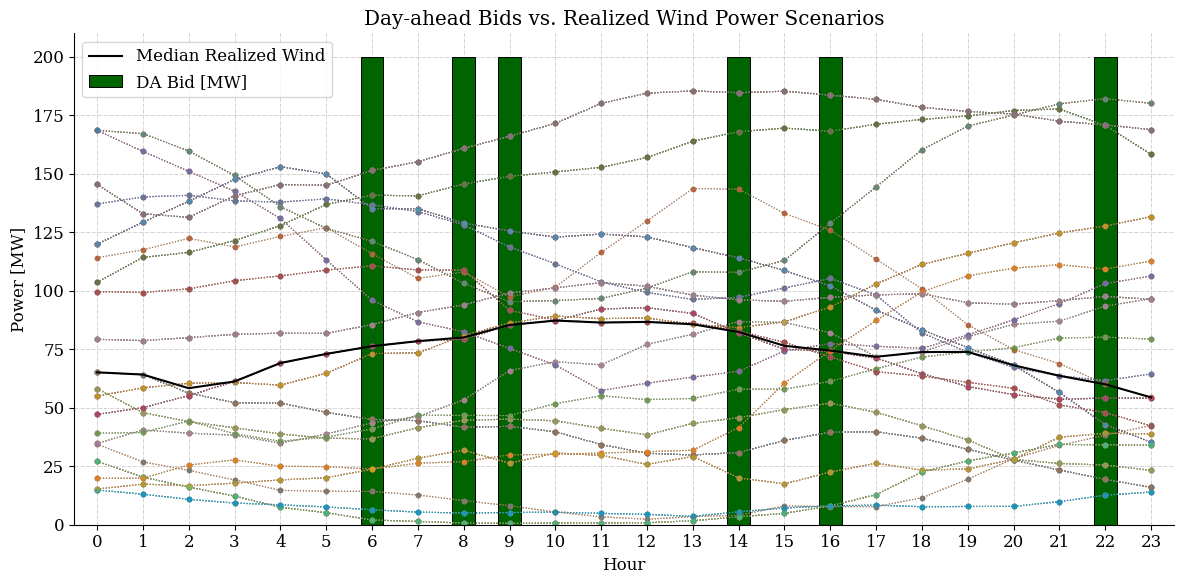

In [86]:
DA_bids = [p_DA[t].x for t in range(T)]

fig = plt.figure(figsize=(12, 6))
ax1 = fig.gca()
#plot day-ahead bid for each hour
results['Summary']['DA Bid [MW]'].to_frame().plot.bar(ax = ax1, label='Day-ahead bid', color='darkgreen', edgecolor='black', linewidth=0.7, align='center', width=0.5)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Power [MW]')


for w in range(OMEGA):
    #plot realized wind power as lines with dots
    results[w]['Wind Power [MW]'].plot(ax = ax1, linestyle=':', marker='o', markersize=3, alpha = 0.4, linewidth=0.8, label = '_nolegend_')

#plot median realized wind power across scenarios as black line
median_wind = np.median([results[w]['Wind Power [MW]'] for w in range(OMEGA)], axis=0)

ax1.plot(median_wind, color='black', linewidth=1.5, label='Median Realized Wind')
ax1.legend()
ax1.set_title('Day-ahead Bids vs. Realized Wind Power Scenarios')
ax1.set_axisbelow(True)

fig.tight_layout()
plt.show()

# Two-price Scheme

*(Task 1.b)*

## Run model

In [87]:
OMEGA = len(scenarios.keys()) - 1 # number of scenarios
T = 24 # number of hours
PI = 1 / OMEGA # probability of each scenario - assumed to be equal
WIND_CAPACITY = 200 #MWh

direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

#============= Variables =============
p_DA = m.addVars(T, lb=0, ub=gb.GRB.INFINITY, name="p_DA") # day-ahead power bid

delta = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="delta") # decision variable for the power imbalance - can be negative
delta_up = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="delta_up") # surplus
delta_down = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="delta_down") # deficit

imbalance_revenue = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="I") # imbalance revenue - can be negative

# binary variables used to control the two-price logic
y = m.addVars(T, OMEGA, vtype=gb.GRB.BINARY, name="y")
z = m.addVars(4, T, OMEGA, vtype=gb.GRB.BINARY, name="z")

#============= Objective function =============
# Set objective function
obj = gb.quicksum(PI * (scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * p_DA[t] + imbalance_revenue[t,w]) for t in range(T) for w in range(OMEGA))
m.setObjective(obj, direction)

#============= Day-ahead power bid limits ============

#Upper limit is the nominal wind power
m.addConstrs(p_DA[t] <= WIND_CAPACITY for t in range(T))

#============= Power imbalance definitions ===============
m.addConstrs(delta[t,w] == scenarios[str(w)]['Wind Power [MW]'][t] - p_DA[t] for t in range(T) for w in range(OMEGA))
m.addConstrs(delta[t,w] == delta_up[t,w] - delta_down[t,w] for t in range(T) for w in range(OMEGA))

#ensure that only one of the delta directions can be non-zero
m.addConstrs(delta_up[t,w] <= M * (1 - y[t,w]) for t in range(T) for w in range(OMEGA))
m.addConstrs(delta_down[t,w] <= M * y[t,w] for t in range(T) for w in range(OMEGA))

#============= Linearized conditional statements ===============
M = 1e6 # big-M constant

#Binary variable constraints
m.addConstrs(z[0,t,w] <= y[t,w] + scenarios[str(w)]['System Balance State'][t] for t in range(T) for w in range(OMEGA))
m.addConstrs(z[1,t,w] <= y[t,w] + (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))
m.addConstrs(z[2,t,w] <= (1 - y[t,w]) + scenarios[str(w)]['System Balance State'][t] for t in range(T) for w in range(OMEGA))
m.addConstrs(z[3,t,w] <= (1 - y[t,w]) + (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))

# if system is in a surplus and the imbalance is positive (NOT helping the system)
m.addConstrs(imbalance_revenue[t,w] <= 0.9 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_up[t,w] + M * z[0,t,w] for t in range(T) for w in range(OMEGA))

# if system is in a deficit and the imbalance is positive (IS helping the system)
m.addConstrs(imbalance_revenue[t,w] <= 1.0 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_up[t,w] + M * z[1,t,w] for t in range(T) for w in range(OMEGA))

# if system is in a surplus and the imbalance is negative (IS helping the system)
m.addConstrs(imbalance_revenue[t,w] <= -1.0 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_down[t,w] + M * z[2,t,w] for t in range(T) for w in range(OMEGA))

# if system is in a deficit and the imbalance is negative (NOT helping the system)
m.addConstrs(imbalance_revenue[t,w] <= -1.2 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_down[t,w] + M * z[3,t,w] for t in range(T) for w in range(OMEGA))

#============= Display and run model =============
m.update()
#m.display()
m.optimize()

#============= Results =============
if m.status == gb.GRB.OPTIMAL:
    #initialization
    results = {}
    for scenario in range(OMEGA):
        df = pd.DataFrame(columns=['Hour', 'DA Price [EUR/MWh]', 'Wind Power [MW]', 'DA Bid [MW]', 'Delta [MW]', 'Delta UP [MW]', 'Delta DOWN [MW]' ,'DA Profit [EUR]', 'Balancing Profit [EUR]', 'System State'])
        
        for t in range(T):
            df.loc[t] = [t, 
                         scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t], 
                         scenarios[str(scenario)]['Wind Power [MW]'][t], p_DA[t].x,
                         delta[t,scenario].x, 
                         delta_up[t,scenario].x, 
                         delta_down[t,scenario].x, 
                         scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * p_DA[t].x, 
                         imbalance_revenue[t,scenario].x, 
                         scenarios[str(scenario)]['System Balance State'][t]]
        df['Total Profit [EUR]'] = df['DA Profit [EUR]'] + df['Balancing Profit [EUR]']

        df['Hour'] = df['Hour'].astype(int)
        df['System State'] = df['System State'].astype(int)
        df['System State'] = df['System State'].apply(lambda x: 'Deficit' if x == 1 else 'Surplus')
        df.set_index('Hour', inplace=True)
        results[scenario] = df.copy(deep=True)

    print('-----------------------------------------------')
    print('Objective value (expected profit): %.2f EUR' % m.objVal)
    print('-----------------------------------------------')
    print('Day-ahead bids:')
    average_hourly_profit = np.mean([results[w]['Total Profit [EUR]'] for w in range(OMEGA)], axis=0)

    summary = pd.DataFrame(columns=['Hour', 'DA Bid [MW]', 'Average Profit [EUR]'])
    for t in range(T):
        summary.loc[t] = [t, p_DA[t].x, average_hourly_profit[t]]
    summary['Hour'] = summary['Hour'].astype(int)
    summary.set_index('Hour', inplace=True)

    results['Summary'] = summary.copy(deep=True)

    for t in range(T):
        print('Hour %d | Bid: %.2f MW | Average Profit: %.2f EUR' % (t, p_DA[t].x, average_hourly_profit[t]))

    print('Sum of average profits: %.2f EUR' % np.sum(average_hourly_profit))
    print('-----------------------------------------------')
    print('Runtime: %f ms' % (m.Runtime * 1e3))
else:
    print("Optimization was not successful.")     

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 72024 rows, 54024 columns and 174024 nonzeros
Model fingerprint: 0x34c3da04
Variable types: 24024 continuous, 30000 integer (30000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [4e-03, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 1e+06]
Found heuristic solution: objective 21650.514532
Presolve removed 46234 rows and 33368 columns
Presolve time: 1.06s
Presolved: 25790 rows, 20656 columns, 63920 nonzeros
Variable types: 15498 continuous, 5158 integer (5158 binary)

Root relaxation: objective 2.219241e+05, 17340 iterations, 0.19 seconds (0.22 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   G

Check that the z-variables are (likely) working as intended...

In [74]:
for scenario in range(OMEGA):
    for t in range(T):
        if np.round(sum([z[i,t,scenario].x for i in range(4)]), 4) != 3:
            print('WARNING: SCENARIO %d | HOUR %d | z:' % (scenario, t), z[0,t,scenario].x, z[1,t,scenario].x, z[2,t,scenario].x, z[3,t,scenario].x)

Check that results make sense for different scenarios

In [75]:
results[5]

,DA Price [EUR/MWh],Wind Power [MW],DA Bid [MW],Delta [MW],Delta UP [MW],Delta DOWN [MW],DA Profit [EUR],Balancing Profit [EUR],System State,Total Profit [EUR]
Hour,,,,,,,,,,
0,52.900002,58.187117,34.731828,23.455289,23.455289,0.000000,1837.313756,1116.706350,Surplus,2954.020106
1,51.160000,47.908830,17.363054,30.545776,30.545776,0.000000,888.293833,1406.449715,Surplus,2294.743548
2,49.810001,44.061606,39.144107,4.917499,4.917499,0.000000,1949.768015,244.940628,Deficit,2194.708643
3,49.029999,41.399280,38.258844,3.140436,3.140436,0.000000,1875.831077,138.578013,Surplus,2014.409091
4,52.470001,38.802331,59.646459,-20.844128,0.000000,20.844128,3129.649785,-1093.691430,Surplus,2035.958355
5,58.970001,36.938998,48.027292,-11.088294,0.000000,11.088294,2832.169455,-653.876716,Surplus,2178.292739
6,62.410000,36.735119,110.630951,-73.895832,0.000000,73.895832,6904.477655,-4611.838871,Surplus,2292.638784
7,66.550003,41.463307,46.834718,-5.371411,0.000000,5.371411,3116.850652,-428.960910,Deficit,2687.889741
8,69.910004,44.654126,93.966016,-49.311891,0.000000,49.311891,6569.164587,-3447.394463,Surplus,3121.770123


## Visualize results

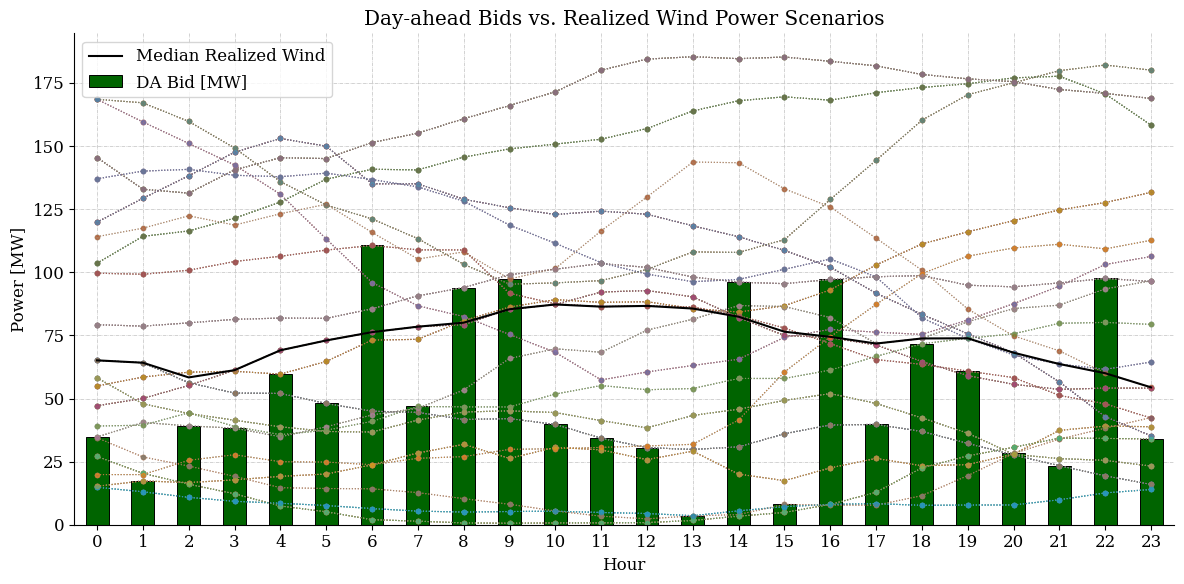

In [84]:
DA_bids = [p_DA[t].x for t in range(T)]

fig = plt.figure(figsize=(12, 6))
ax1 = fig.gca()
#plot day-ahead bid for each hour
results['Summary']['DA Bid [MW]'].to_frame().plot.bar(ax = ax1, label='Day-ahead bid', color='darkgreen', edgecolor='black', linewidth=0.7, align='center', width=0.5)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Power [MW]')


#plot realized wind power as lines with dots
for w in range(OMEGA):
    results[w]['Wind Power [MW]'].plot(ax = ax1, linestyle=':', marker='o', markersize=3, alpha = 0.3, linewidth=0.8, label = '_nolegend_')

#plot median realized wind power across scenarios as black line
median_wind = np.median([results[w]['Wind Power [MW]'] for w in range(OMEGA)], axis=0)

ax1.plot(median_wind, color='black', linewidth=1.5, label='Median Realized Wind')

ax1.legend()
ax1.set_title('Day-ahead Bids vs. Realized Wind Power Scenarios')
ax1.set_axisbelow(True)

fig.tight_layout()
plt.show()

Similar plot with day-ahead prices instead of realized wind

Similar plot with average system state per hour